<a href="https://colab.research.google.com/github/Bepo2002/Humbug-4YP/blob/pipeline_creation/Test_bench_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Bench V2

### Using mel-spectrograms instead of average mel coefficients

## Functions

In [170]:
pip install visualkeras

ERROR: Operation cancelled by user


In [171]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import tensorflow as tf
from IPython.display import Audio
import matplotlib.pyplot as plt
import matplotlib.colors as mclr
import librosa
import visualkeras

In [172]:
# Finds specific sound in zip and extracts it
def extract_sound(filename,silent = False):
  zip_files = ['./drive/MyDrive/4YP/train.zip','./drive/MyDrive/4YP/dev.zip']
  folders = ['train/', 'dev/a/', 'dev/b/']
  dest_dir = './drive/MyDrive/4YP/Data'
  filename_to_extract = str(filename) + '.wav'

  for zip_path in zip_files:
    for folder in folders:
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        filename_to_extract = folder + filename_to_extract
        if filename_to_extract in zip_ref.namelist():
          zip_ref.extract(filename_to_extract, dest_dir)
          if not silent:
            print(f"{filename_to_extract} has been extracted to {dest_dir}")
          final = './drive/MyDrive/4YP/Data/'+ filename_to_extract
          return wavfile.read(final)
  print(f"{filename_to_extract} not found in any of the provided ZIP files.")

# Read in .csv
def csv_read():
  metadata = pd.read_csv('./drive/MyDrive/4YP/Data/humbugdb_zenodo_edited.csv')
  metadata = metadata.set_index('id')
  return metadata

def gaussian(x, mu, sigma):
  return np.exp(-((x - mu)**2) / (2 * sigma**2))

# Normalise audio
def normalize_audio(audio, target_dBFS=0):
  # Calculate the current dBFS of the audio
  rms = np.sqrt(np.mean(np.square(audio)))
  current_dBFS = 20 * np.log10(rms)

  # Calculate the required gain to achieve the target dBFS
  gain = target_dBFS - current_dBFS

  # Apply gain to the audio data
  normalized_audio = audio * (10 ** (gain / 20))

  return normalized_audio

In [173]:
# Full function for generating noise + mosquito
def long_sound_gen(mos_num,noise_factor=1,silent=False):
  metadata = csv_read()

  # Choose a long noise sound
  subset = metadata[(metadata['sound_type'] == 'background') &
                  (metadata['length'] > 10) &
                  (metadata['sample_rate'] == 44100) &
                  (metadata['clean'] == "Y")]

  noise_id = subset.sample().index.values[0]

  # Extract the sound wave and find samplerate
  n_samplerate, noise = extract_sound(noise_id,silent)

  # Normalise
  noise = normalize_audio(noise/100)

  # Choose a shorter mosquito sound
  subset = metadata[(metadata['sound_type'] == 'mosquito') &
                    (metadata['length'] < 10) &
                    (metadata['length'] > 1) &
                    (metadata['sample_rate'] == 44100)]

  mos_id = subset.sample().index.values[0]

  # Import the sound wave and find samplerate
  samplerate, data = extract_sound(mos_id)

  # Normalise
  data = normalize_audio(data/100)

  # Add sound to random time in noise
  # Initilise vectors to store new audio and whether each sample is from mosquito or noise
  new_audio = np.zeros(noise.size)
  sound_cat = np.zeros(noise.size)
  old_audio = np.zeros(noise.size)

  for i in range(0,mos_num):

    # Choose a 'time' to put the middle of mosquito sound wave
    mosquito_time = np.random.randint(data.size//2,
                                      high=noise.size-data.size//2,
                                      dtype=int)
    print("Adding mosquito noise at ", str(round(mosquito_time/samplerate,3)),
          "s")

    # Put wave into long array
    new_audio[mosquito_time - data.size//2:(mosquito_time - data.size//2)+data.size] = data
    sound_cat[mosquito_time - data.size//2:mosquito_time + data.size//2] = 1

    # Generate gaussian in same place as mos audio
    x = np.linspace(0,noise.size,noise.size,dtype=int)
    y = gaussian(x,mosquito_time,data.size/6)

    # Multiply to apply gaussian to audio
    old_audio = y*new_audio + old_audio

  # Add faded mosquito sound to background noise
  full_audio = noise*noise_factor + old_audio

  return full_audio, samplerate, sound_cat

In [174]:
# Convert numbers to 0 or 1 depending on threshold
def binarize(input_array,thresh = 0):
  output_array = np.zeros(len(input_array))
  for i in range(len(input_array)):
    if input_array[i] > thresh:
      output_array[i] = 1
    else:
      output_array[i] = 0

  return output_array

In [175]:
# Chops the audio clip into sections and creates a vector of clips
def chop_chop(audio,samplerate,seconds_per_clip=1):
  # Choose bin size (default 1 second clip)
  bin_size = int(samplerate*seconds_per_clip)

  # Reshape Data
  rows = int(audio.size/bin_size)
  audio = audio[:rows*bin_size]
  audio = np.reshape(audio,(rows,bin_size))
  audio = np.concatenate((audio,np.zeros((rows,1))),axis=1)
  return audio

## More helper functions

In [102]:
def generate_training_data(mosquitoness=1, noise_factor=0.5, chop_size=3,silent=False):
  # Create the long mixed audio (mosquito + noise)
  full_audio, samplerate, sound_cat = long_sound_gen(mosquitoness,noise_factor,silent)

  # Chop audio into X second clips
  chopped_audio = chop_chop(full_audio,samplerate,chop_size)

  # Create an average 'mosquitoness' of each clip
  chopped_cat = chop_chop(sound_cat,samplerate,chop_size)
  av_chopped_cat = np.mean(chopped_cat,axis=1)

  # Generate spectrogram for each clip
  spectro = np.zeros((len(chopped_audio),128,259))
  for i in range(0,len(chopped_audio)):
    mel_spect = librosa.feature.melspectrogram(y=chopped_audio[i],
                                               sr=samplerate, n_fft=1024)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    mel_spect = (mel_spect + 80) / 80
    spectro[i] = mel_spect

  # Returns a number of seconds in audio x n_mfcc matrix and an array of sound category (how much mosquito) in each X second chop
  return spectro, av_chopped_cat

In [17]:
def multiple_training_data(amount_of_audio, mosquitoness=2, noise_factor=0.5,
                           chop_size=3,silent=False):
  X, Y = generate_training_data(mosquitoness, noise_factor, chop_size,silent)
  for i in range(0,amount_of_audio-1):
    specto, av_chopped_cat = generate_training_data(mosquitoness, noise_factor,
                                                   chop_size,silent)
    X = np.concatenate((X,specto))
    Y = np.concatenate((Y,av_chopped_cat))
  return X,Y

## Convolutional Neural Network Demo

### Generate the data

In [ ]:
X,Y = multiple_training_data(100,mosquitoness=1, noise_factor=0.1, chop_size=3,
                             silent = True)

In [104]:
print("Mosquito Clips: ", np.count_nonzero(Y))
print("Background Clips: ", len(Y)-np.count_nonzero(Y))
print("Total: ", len(Y))

Mosquito Clips:  252
Background Clips:  229
Total:  481


In [105]:
from sklearn.model_selection import train_test_split
Y_bin = binarize(Y,thresh = 0.5)
print("Mosquito Clips: ", np.count_nonzero(Y_bin))
print("Background Clips: ", len(Y_bin)-np.count_nonzero(Y_bin))
print("Total: ", len(Y_bin), '\n')
X_train, X_dev, y_train, y_dev = train_test_split(X, Y_bin, test_size=0.2,
                                                  random_state=42)


X_train = X_train.reshape(-1, 128, 259, 1)
X_dev = X_dev.reshape(-1, 128, 259, 1)

print("Training set size: ", X_train.shape[0])
print("Validation set size: ", X_dev.shape[0])

Mosquito Clips:  178
Background Clips:  303
Total:  481 

Training set size:  384
Validation set size:  97


Example of what the network "sees" as its input:

1.0


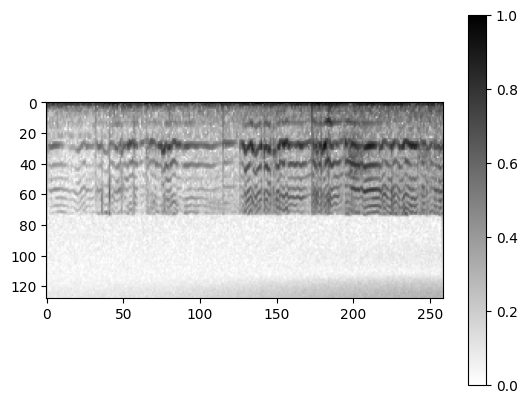

In [127]:
num = 16
testy = X_train[num].reshape(128, 259)
plt.imshow(testy,cmap="binary")
plt.colorbar() ;
print(y_train[num])
plt.show()

### Configure the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 255, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 127, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 127, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 123, 64)       51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 61, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 29, 61, 64)        0

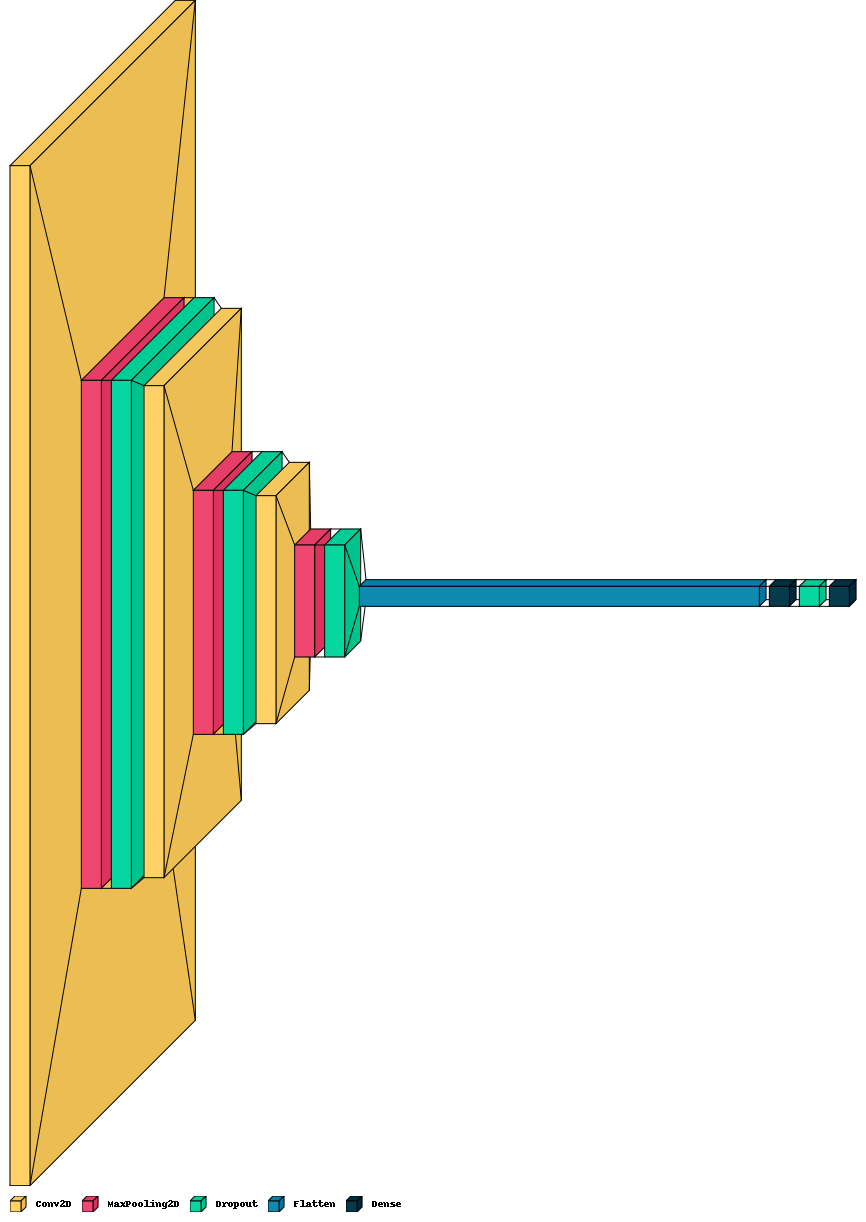

In [155]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation="relu",
                           input_shape=(128, 259, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=128, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1)
])

model.summary()
visualkeras.layered_view(model,legend=True)

In [156]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=["accuracy"])

In [158]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss",     # Monitor the validation loss
                               patience=50,            # Number of epochs with no improvement after which training will be stopped
                               verbose=1,              # Whether to output a message when training is stopped
                               baseline=0.1,           # Stop if loss is lower than 0.1
                               restore_best_weights=True) # Whether to restore model weights from the epoch with the best value of the monitored quantity


history = model.fit(X_train, y_train, epochs=200, validation_data=(X_dev, y_dev),
                    callbacks=[early_stopping])

Epoch 1/200
12/12 [==============================] - 1s 65ms/step - loss: 0.3865 - accuracy: 0.8177 - val_loss: 0.4731 - val_accuracy: 0.7010
Epoch 2/200
12/12 [==============================] - 1s 55ms/step - loss: 0.4063 - accuracy: 0.8516 - val_loss: 0.5351 - val_accuracy: 0.6701
Epoch 3/200
12/12 [==============================] - 1s 57ms/step - loss: 0.3631 - accuracy: 0.8646 - val_loss: 0.4024 - val_accuracy: 0.7423
Epoch 4/200
12/12 [==============================] - 1s 55ms/step - loss: 0.3036 - accuracy: 0.8958 - val_loss: 0.3627 - val_accuracy: 0.8454
Epoch 5/200
12/12 [==============================] - 1s 54ms/step - loss: 0.2108 - accuracy: 0.9193 - val_loss: 0.2915 - val_accuracy: 0.9485
Epoch 6/200
12/12 [==============================] - 1s 54ms/step - loss: 0.2214 - accuracy: 0.9141 - val_loss: 0.2767 - val_accuracy: 0.8660
Epoch 7/200
12/12 [==============================] - 1s 54ms/step - loss: 0.2319 - accuracy: 0.9036 - val_loss: 0.3612 - val_accuracy: 0.9175
Epoch 

### Analyse results

4/4 [==============================] - 0s 11ms/step
Correct:  89
Incorrect:  8


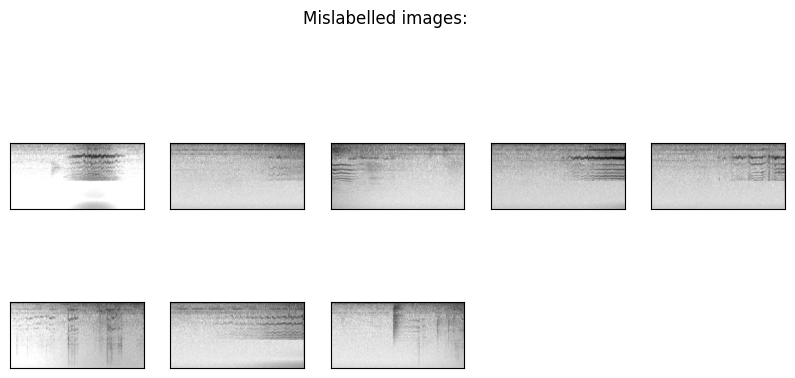

In [178]:
y_pred = model.predict(X_dev)
y_pred = (1 / (1 + np.exp(-y_pred))).round().astype(int)

correct = y_pred.flatten() == y_dev


correctly_classified_images = X_dev[correct]
incorrectly_classified_images = X_dev[~correct]

print("Correct: ", len(correctly_classified_images))
print("Incorrect: ", len(incorrectly_classified_images))

def display_images(images, num_images=10):
    plt.figure(figsize=(10,10))
    plt.suptitle("Mislabelled images:")
    for i in range(num_images):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
    plt.show()

# Display first 10 incorrectly classified images
display_images(incorrectly_classified_images, len(incorrectly_classified_images))

True positive: 34
True negative: 55
False positive: 2
False negative: 6
Sensitivity: 0.85
Specificity: 0.9649122807017544
Score: 1.9298245614035088


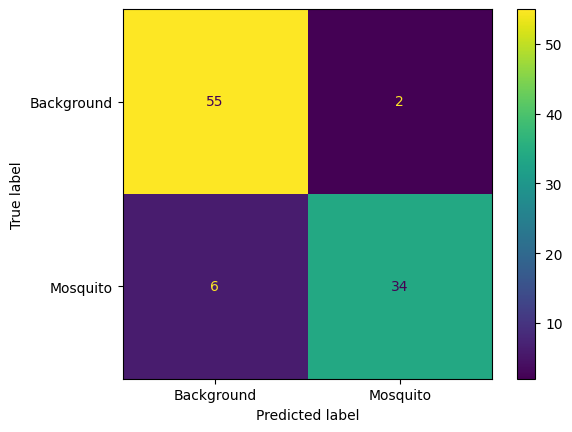

In [177]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(y_dev, y_pred)
true_pos = confusion[1][1]
true_neg = confusion[0][0]
false_pos = confusion[0][1]
false_neg = confusion[1][0]

print("True positive: " + str(true_pos))
print("True negative: " + str(true_neg))
print("False positive: " + str(false_pos))
print("False negative: " + str(false_neg))

sensitivity = true_pos/(true_pos+false_neg)
specificity = true_neg/(true_neg+false_pos)

print("Sensitivity: " + str(sensitivity))
print("Specificity: " + str(specificity))
print("Score: " + str(specificity+specificity))
disp = ConfusionMatrixDisplay(confusion, display_labels = ["Background", "Mosquito"])
disp.plot()
plt.show()